In [562]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_optim
from sklearn.decomposition import PCA

# DAR

In [401]:
# Load data
data = np.genfromtxt('xbtusd.csv', delimiter=',')
Y = data[1:,-1] # get de-trended BITCOIN prices. Also, remove first value, since it is NaN.

## Estimate DAR

In [395]:
def MLE_DAR(Y):
    def loglikelihood_function(params):

        rho, omega, alpha = params
        
        # define time t
        T = len(Y)
        max_lag = 1 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(T-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # Define function objects at time t
        y = lambda t: (Y[t])
        sigma = lambda t: np.sqrt(omega + alpha * (y(t-1) ** 2))
        cond_mean = lambda t: rho * y(t-1)
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(sigma(t)**2)
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    init_params = np.array([rho_init, omega_init, alpha_init])

    # set parameter bounds
    rho_bound = (0,None)
    omega_bound = (0,None)
    alpha_bound = (0,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

## Simulate DAR

In [ ]:
def DAR_sim(parameters, T, set_seed):
    np.random.seed(set_seed)
    rho, omega, alpha = parameters

    max_lag = 1
    
    # Initialize arrays
    Y = np.zeros(T)
    Z = np.random.normal(loc=0, scale=1, size=T)

    # Initialize the process
    Y[0] = 1 

    # Define function objects at time t
    y = lambda t: Y[t]
    z = lambda t: Z[t]
    sigma = lambda t: np.sqrt(omega + alpha * Y[t-1]**2)
    epsilon = lambda t: sigma(t) * z(t)

    # The model
    DAR = lambda t: rho * y(t-1) + epsilon(t)

    # Update Y
    for t in range(max_lag, T):
        Y[t] = DAR(t)
    return Y

In [ ]:
rho_sim = 1
omega_sim = 20
alpha_sim = 0.1
T_sim = 1000

parameters_sim = rho_sim, omega_sim, alpha_sim
DAR_simulated = DAR_sim(parameters_sim, T = T_sim, set_seed = 422413)

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(DAR_simulated, label='Simulated data 1')
plt.grid()
plt.legend()

# DARMA

## Estimate DARMA

In [770]:
def MLE_DARMA(Y):

    Y = Y.flatten()
    T = len(Y)


    def loglikelihood_function(params):

        rho, omega, alpha, phi = params
        
        # define time t
        max_lag = 2 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(T-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # Define function objects at time t
        y = lambda t: (Y[t])
        sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
        beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)
        
        cond_mean = lambda t: rho * y(t-1) + sigma(t) * beta(t-1)
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(sigma(t)**2)
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / sigma(t)**2
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    phi_init = 0.0
    init_params = np.array([rho_init, omega_init, alpha_init, phi_init])

    # set parameter bounds
    rho_bound = (0,None)
    omega_bound = (0.0001,None)
    alpha_bound = (0,None)
    phi_bound = (None,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound,phi_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

In [419]:
DARMA_MLE_params = MLE_DARMA(Y)

## Simulate DARMA

In [ ]:
def DARMA_sim(parameters, T, set_seed):
    np.random.seed(set_seed)
    rho, omega, alpha, phi = parameters

    max_lag = 2
    
    # Initialize arrays
    Y = np.zeros(T)
    ETA = np.random.normal(loc=0, scale=1, size = T)

    # Initialize the process
    Y[0] = 1 

    # Define function objects at time t
    y = lambda t: Y[t]
    eta = lambda t: ETA[t]
    sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
    beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)
    
    # The model
    DARMA = lambda t: rho * y(t-1) + sigma(t) * beta(t-1) + sigma(t) * eta(t)

    # Recursively comput the model
    for t in range(max_lag, T):
        Y[t] = DARMA(t)
    return Y

In [ ]:
rho_sim = 1
omega_sim = 20
alpha_sim = 0.1
phi_sim = 0.4
T_sim = 1000

parameters_sim = rho_sim, omega_sim, alpha_sim, phi_sim
DARMA_simulated = DARMA_sim(parameters_sim, T = T_sim, set_seed = 422413)

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(DARMA_simulated, label='Simulated data 1')
plt.grid()
plt.legend()

## Forecasting DARMA

In [ ]:
def DARMA_forecast(parameters, Y):
    
    rho, omega, alpha, phi = parameters

    t = -1 # define start index 

    # Define function objects at time t
    y = lambda t: Y[t]
    sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
    beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)

    # Expected Mean
    expected_mean = rho * y(t) + sigma(t+1) * beta(t)

    return expected_mean

In [ ]:
def DARMA_forecast_array(parameters, Y):
    T = len(Y) + 1
    max_lag = 2

    expected_mean_array = []
    expected_mean_array.extend(np.nan for i in range(0, max_lag))
    
    for t in range(max_lag, T):
        expected_mean_t = DARMA_forecast(parameters,Y[:t])
        expected_mean_array.append(expected_mean_t)

    
    expected_mean_array = np.array(expected_mean_array)

    return expected_mean_array

In [ ]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(Y, label='Observed data')
plt.plot(DARMA_forecast_array(DARMA_MLE_params, Y), label='Forecast')
plt.grid()
plt.legend()

# Dimensionality Reduction with Principal Component Analysis

In [805]:
# Load data
datasets = {}
for hour in range(24): # 24
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}

X = weather_train[0]
Y = y_train[0]

In [806]:
def PCA_dimreduc(training_data, test_data, exp_var_pct):

    # Compute mean (bias) of training data
    PCA_bias = np.mean(training_data, axis=0)

    # Find number of loadings mathcing the level of explained variance
    pca = PCA()
    pca.fit(training_data)
    components = pca.components_
    eigvals_i = (pca.singular_values_) ** 2 # eigenvalues equals the squared singular values
    explained_variance_cumsum = np.array(list(enumerate((np.cumsum(eigvals_i) / np.sum(eigvals_i)), start=1))) # computing cummulative explained variancec with correct index
    K_loadings = min(np.where(explained_variance_cumsum[:,1] >= exp_var_pct)[0]) + 1 # number of components to explain X pct. variance

    # Extract first K principal components (PCA loadings) necessary to match the chosen level of explained variance
    PCA_loadings = components[0:K_loadings, :].T

    # Compute dimensinality reduced data by projecting the centered test_data onto the first K principal components
    data_dimreduc = (test_data - PCA_bias) @ PCA_loadings
    
    return data_dimreduc, PCA_loadings, PCA_bias, K_loadings, explained_variance_cumsum

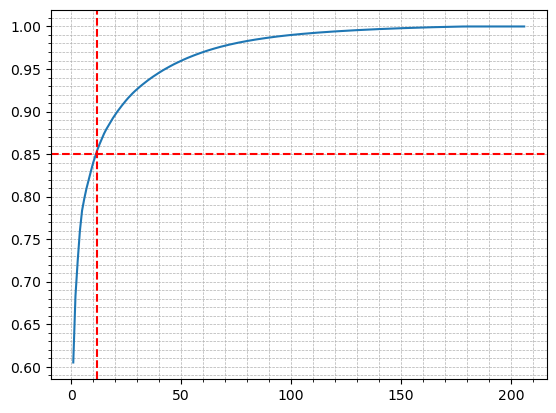

In [807]:
X_dimreduc = PCA_dimreduc(X, X, 0.85)[0]
K_loadings = PCA_dimreduc(X, X, 0.85)[3]
exp_variance_level = 0.85
explained_variance = PCA_dimreduc(X, X, exp_variance_level)[-1]

plt.plot(explained_variance[:,0],explained_variance[:,1])
plt.axvline(x = K_loadings, color='red', linestyle='--', label=f'')
plt.axhline(y = exp_variance_level, color='red', linestyle='--', label=f'')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)


# ARCH-X

In [779]:
def MLE_ARCHX(Y, X):
    
    Y = Y.flatten()
    T = len(Y)
    d = X.shape[1]
    
    def loglikelihood_function(params):

        omega, alpha, *gamma = params
        
        # define time t
        max_lag = 1 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(T-(max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # Define function objects at time t
        y = lambda t: Y[t]
        x = lambda t: X[t]
        sigma = lambda t: np.sqrt(omega + alpha * y(t-1) ** 2 + gamma @ (x(t-1)**2).T)
        
        # Define conditional expectation and conditional variance
        cond_mean = lambda t: 0
        cond_var = lambda t: sigma(t)**2
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(cond_var(t))
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / cond_var(t)
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    omega_init = 0.05
    alpha_init = 0.5
    gamma_init = [0.5 for _ in range(d)]
    init_params = np.concatenate([[omega_init, alpha_init], gamma_init])

    # set parameter bounds
    omega_bound = (0.0001,None)
    alpha_bound = (0,None)
    gamma_bound = [(0, None) for _ in range(d)]
    bounds_params = (omega_bound, alpha_bound, *gamma_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

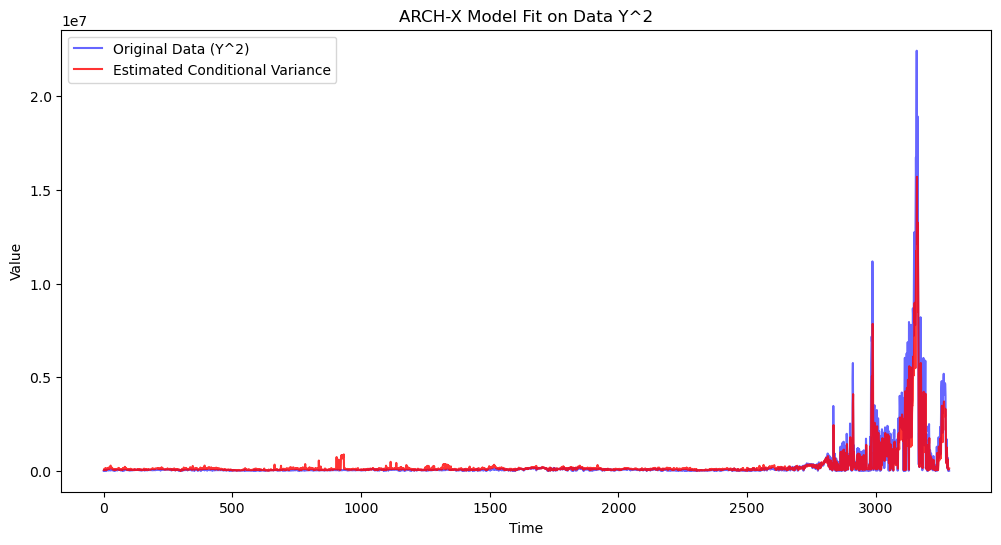

In [780]:
def plot_ARCHX_fit(Y, X, estimated_params):
    T = len(Y)
    d = X.shape[1]
    Y = Y.flatten()

    # Unpack the estimated parameters
    omega, alpha, *gamma = estimated_params
    gamma = np.array(gamma)

    # Define the range for valid time indices
    max_lag = 1
    t_range = np.arange(max_lag, T)

    # Define function objects for time t
    y = lambda t: Y[t]
    x = lambda t: X[t]

    # Compute the estimated conditional variances
    sigma = lambda t: np.sqrt(omega + alpha * y(t - 1) ** 2 + gamma @ (x(t - 1)**2).T)
    cond_variances = [sigma(t) ** 2 for t in t_range]

    # Plot the original data Y and the estimated conditional variances
    plt.figure(figsize=(12, 6))
    plt.plot(Y**2, label='Original Data (Y^2)', color='blue', alpha=0.6)
    plt.plot(t_range, cond_variances, label='Estimated Conditional Variance', color='red', alpha=0.8)
    plt.title('ARCH-X Model Fit on Data Y^2')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

ARCH_X_params = MLE_ARCHX(Y, X_dimreduc)
plot_ARCHX_fit(Y,X_dimreduc, ARCH_X_params)

# DARMA-X

## Estimate DARMA-X

In [1062]:
def MLE_DARMAX(Y,X):

    T = len(Y)
    d = X.shape[1]
    Y = Y.flatten()

    def loglikelihood_function(parameters):

        rho, omega, alpha, phi, *gamma = parameters
        
        # define time t
        max_lag = 2 # maximum lag in the model
        start_index = -1 # set -1 since the latest time series observation is the last value in Y
        stop_index = -(T - (max_lag - 1))
        t = np.arange(start = start_index, stop = stop_index, step = -1)
        
        # Define function objects at time t
        y = lambda t: Y[t]
        x = lambda t: X[t]
        sigma = lambda t: np.sqrt(omega + alpha * y(t - 1) ** 2 + gamma @ (x(t-1)**2).T)
        beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)
        
        # Define conditional expectation and conditional variance at time t
        cond_mean = lambda t: rho * y(t-1) + sigma(t) * beta(t-1)
        cond_var = lambda t: sigma(t)
        
        # compute sum of likelihood contributions
        first_term = -1/2 * np.log(cond_var(t))
        second_term = -1/2 * (y(t) - cond_mean(t))**2 / cond_var(t)
        L_t = np.sum(first_term + second_term)
        
        return -L_t
    
    # initialise parameters
    rho_init = 0.5
    omega_init = 0.05
    alpha_init = 0.5
    phi_init = 0.0
    gamma_init = [0.5 for _ in range(d)]
    init_params = np.concatenate([[rho_init, omega_init, alpha_init, phi_init], gamma_init])

    # set parameter bounds
    rho_bound = (None,None)
    omega_bound = (0.0001,None)
    alpha_bound = (0,None)
    phi_bound = (None,None)
    gamma_bound = [(0, None) for _ in range(d)]
    bounds_params = (rho_bound, omega_bound, alpha_bound, phi_bound, *gamma_bound)

    MLE_estimates = sci_optim.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

In [1063]:
DARMA_MLE_params = MLE_DARMAX(Y, X_dimreduc) 
DARMA_MLE_params[0]

0.9690616400348367

## Forecasting DARMAX

In [1064]:
def DARMAX_forecast(parameters, Y, X):
    
    rho, omega, alpha, phi, *gamma = parameters
    #gamma = np.array(gamma)

    t = -1 # define start index 

    # Define function objects at time t
    y = lambda t: Y[t]
    x = lambda t: X[t]
    sigma = lambda t: np.sqrt(omega + alpha * y(t-1) ** 2 + gamma @ (x(t-1)**2).T)
    beta = lambda t: phi * (y(t) - rho * y(t-1)) / sigma(t)

    # Expected Mean
    expected_mean = rho * y(t) + sigma(t+1) * beta(t)
    
    return expected_mean.item()

In [1065]:
def DARMAX_forecast_array(parameters, Y, X):
    T = len(Y)
    max_lag = 2

    expected_mean_array = []
    expected_mean_array.extend(np.nan for i in range(0, max_lag))
    
    for t in range(max_lag, T):
        expected_mean_t = DARMAX_forecast(parameters, Y[:t], X[:t])
        expected_mean_array.append(expected_mean_t)
    
    return np.array(expected_mean_array)

In [1066]:
DARMA_MLE_params = MLE_DARMAX(Y, X_dimreduc) 
DARMAX_forecast_plot = DARMAX_forecast_array(DARMA_MLE_params, Y, X_dimreduc)

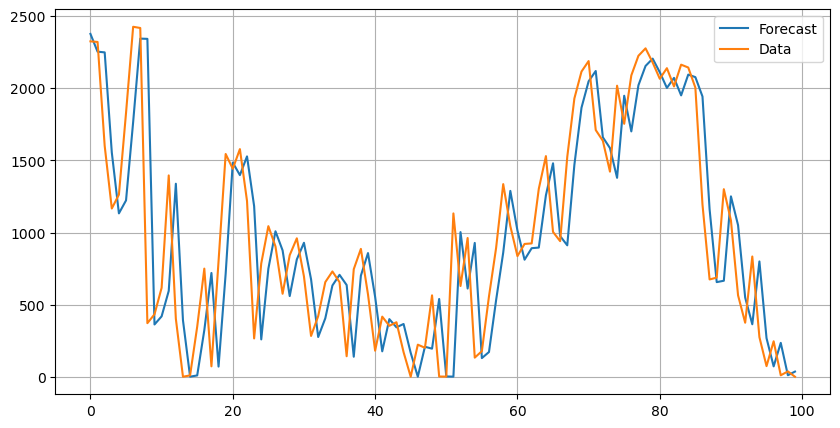

In [1067]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(DARMAX_forecast_plot[-100:], label='Forecast')
plt.plot(Y[-100:], label='Data')
plt.grid()
plt.legend()

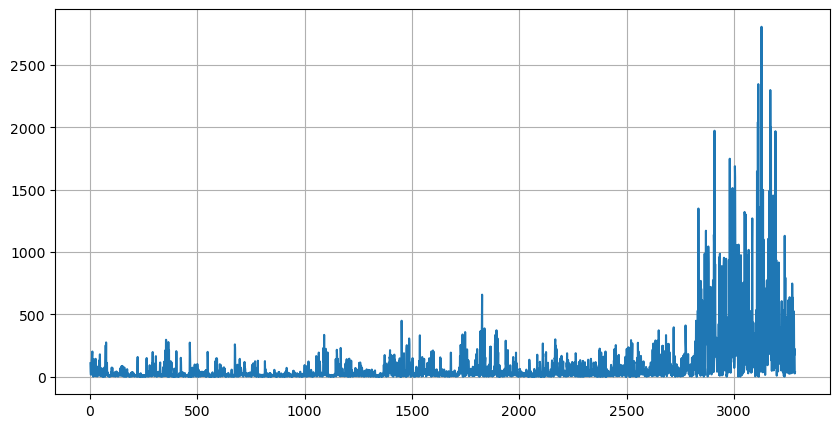

In [1068]:
forecast_error = abs(DARMAX_forecast_plot - Y.flatten())
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(forecast_error, label='error')
plt.grid()
#plt.legend()